# Overview
- nb001の続き

# Const

In [1]:
NB = '003'
isSmallSet = False
LENGTH = 1000

PATH_TRAIN = './../data/input/train.csv'
PATH_TEST = './../data/input/test.csv'
PATH_SMPLE_SUB = './../data/input/sample_submission.csv'
DIR_OUTPUT = './../data/output/'
cp = ['#f8b195', '#f67280', '#c06c84', '#6c5b7b', '#355c7d']
sr = 10*10**3  # 10 kHz

# Import everything I need :)

In [171]:
import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastprogress import progress_bar
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# My function

In [147]:
def f1_macro(true, pred):
    return f1_score(true, pred, average='macro')

class permutation_importance():
    def __init__(self, model, metric):
        self.is_computed = False
        self.n_feat = 0
        self.base_score = 0
        self.model = model
        self.metric = metric
        self.df_result = []
    
    def compute(self, X_valid, y_valid):
        self.n_feat = len(X_valid.columns)
        if self.metric == 'auc':
            y_valid_score = self.model.predict_proba(X_valid)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
            self.base_score = auc(fpr, tpr)
        else:
            pred = np.round(self.model.predict(X_valid)).astype('int8')
            self.base_score = self.metric(y_valid, pred)
        self.df_result = pd.DataFrame({'feat': X_valid.columns, 
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
        
        # predict
        for i, col in enumerate(X_valid.columns):
            df_perm = X_valid.copy()
            np.random.seed(1)
            df_perm[col] = np.random.permutation(df_perm[col])
            y_valid_pred = self.model.predict(df_perm)
            if self.metric == 'auc':
                y_valid_score = self.model.predict_proba(df_perm)[:, 1]
                fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
                score = auc(fpr, tpr)
            else:
                score = self.metric(y_valid, np.round(y_valid_pred).astype('int8'))
            self.df_result['score'][self.df_result['feat']==col] = score
            self.df_result['score_diff'][self.df_result['feat']==col] = self.base_score - score
        self.is_computed = True
    
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] < 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
        
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] > 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    
    def show_permutation_importance(self, score_type='loss'):
        '''score_type = 'loss' or 'accuracy'  '''
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        if score_type=='loss':
            ascending = True
        elif score_type=='accuracy':
            ascending = False
        else:
            ascending = ''
        
#         plt.figure(figsize=(15, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=ascending))
        plt.title('base_score - permutation_score')

# Preparation

setting

In [4]:
sns.set()

<br>

load dataset

In [5]:
df_tr = pd.read_csv(PATH_TRAIN)
df_te = pd.read_csv(PATH_TEST)

<br>

処理のしやすさのために、バッチ番号を振る

In [6]:
batch_list = []
for n in range(10):
    batchs = np.ones(500000)*n
    batch_list.append(batchs.astype(int))
batch_list = np.hstack(batch_list)
df_tr['batch'] = batch_list

batch_list = []
for n in range(4):
    batchs = np.ones(500000)*n
    batch_list.append(batchs.astype(int))
batch_list = np.hstack(batch_list)
df_te['batch'] = batch_list

<br>

smallset?

In [7]:
if isSmallSet:
    print('small set mode')
    # train
    batchs = df_tr['batch'].values
    dfs = []
    for i_bt, bt in enumerate(df_tr['batch'].unique()):
        idxs = batchs == bt
        _df = df_tr[idxs][:LENGTH].copy()
        dfs.append(_df)
    df_tr = pd.concat(dfs).reset_index(drop=True)
    
    # test
    batchs = df_te['batch'].values
    dfs = []
    for i_bt, bt in enumerate(df_te['batch'].unique()):
        idxs = batchs == bt
        _df = df_te[idxs][:LENGTH].copy()
        dfs.append(_df)
    df_te = pd.concat(dfs).reset_index(drop=True)

# EDA

## batch=0 に絞って見てみる

In [23]:
batch = 0
idxs = df_tr['batch'] == batch
df_tr_batch = df_tr[idxs].copy()

<br>

とりあえず plot

Text(0.5, 0, 'time [sec]')

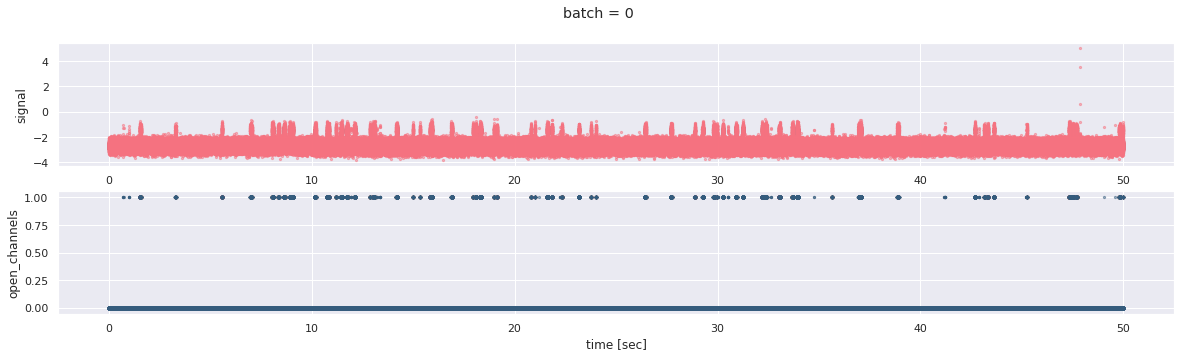

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(20, 5))
axs = axs.ravel()
fig.suptitle(f'batch = {batch}')

axs[0].scatter(df_tr_batch['time'].values, df_tr_batch['signal'].values, color=cp[1], alpha=0.5, s=5)
axs[0].set_ylabel('signal')
axs[1].scatter(df_tr_batch['time'].values, df_tr_batch['open_channels'].values, color=cp[4], alpha=0.5, s=5)
axs[1].set_ylabel('open_channels')
axs[1].set_xlabel('time [sec]')

> signal が大きくなったところで open_channels が開いている  
> もう少し拡大してみよう

<br>

8~8.12秒を可視化

Text(0.5, 0, 'time [sec]')

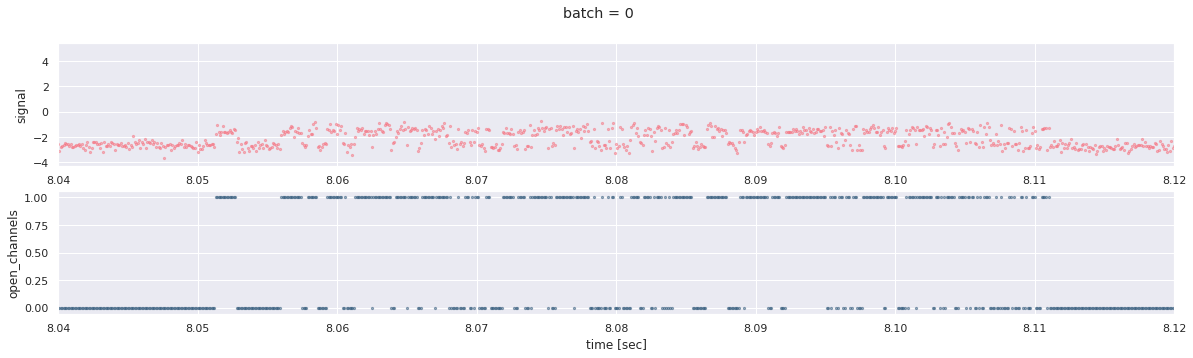

In [38]:
fig, axs = plt.subplots(2, 1, figsize=(20, 5))
axs = axs.ravel()
fig.suptitle(f'batch = {batch}')

# xlim
lim = [8.04, 8.12]
axs[0].set_xlim(lim)
axs[1].set_xlim(lim)

axs[0].scatter(df_tr_batch['time'].values, df_tr_batch['signal'].values, color=cp[1], alpha=0.5, s=5)
axs[0].set_ylabel('signal')
axs[1].scatter(df_tr_batch['time'].values, df_tr_batch['open_channels'].values, color=cp[4], alpha=0.5, s=5)
axs[1].set_ylabel('open_channels')
axs[1].set_xlabel('time [sec]')

> これだけ見ると、signalの大きさだけでopen_channelsを予測できそうなきがするんだが  
> batch=0はかなりシンプルな見た目をしてるので、他のも見てみよう

## batch=4 に絞って見てみる

In [39]:
batch = 4
idxs = df_tr['batch'] == batch
df_tr_batch = df_tr[idxs].copy()

<br>

とりあえず plot

Text(0.5, 0, 'time [sec]')

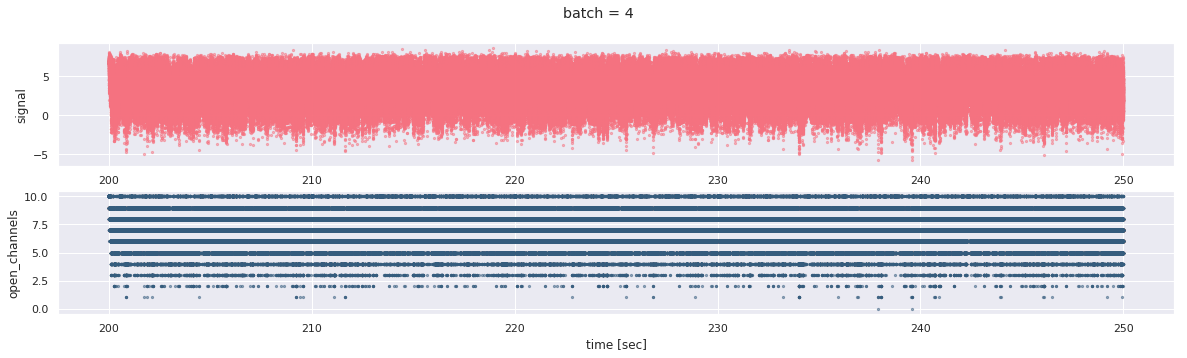

In [40]:
fig, axs = plt.subplots(2, 1, figsize=(20, 5))
axs = axs.ravel()
fig.suptitle(f'batch = {batch}')

axs[0].scatter(df_tr_batch['time'].values, df_tr_batch['signal'].values, color=cp[1], alpha=0.5, s=5)
axs[0].set_ylabel('signal')
axs[1].scatter(df_tr_batch['time'].values, df_tr_batch['open_channels'].values, color=cp[4], alpha=0.5, s=5)
axs[1].set_ylabel('open_channels')
axs[1].set_xlabel('time [sec]')

> 全然わからん...  
> 拡大しよう

<br>

200~201秒を可視化

Text(0.5, 0, 'time [sec]')

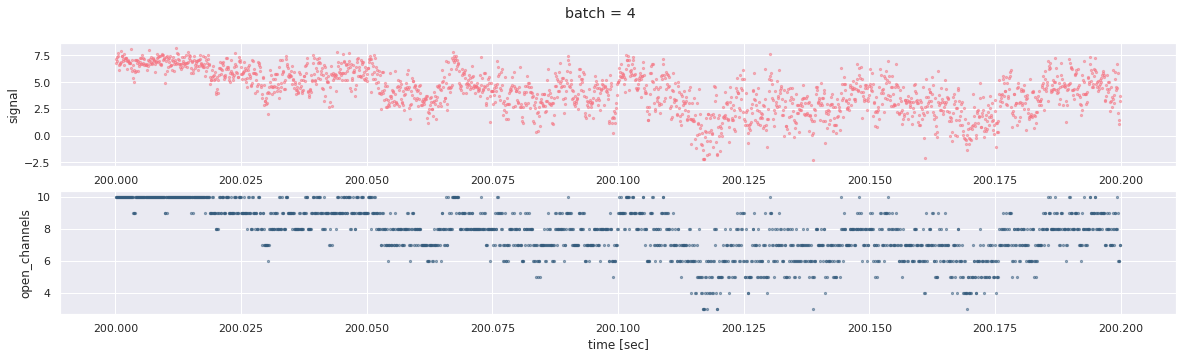

In [44]:
start_sec = 200
end_sec = 200.2

idxs = (start_sec<df_tr['time'].values) & (df_tr['time'].values<end_sec)
_df = df_tr[idxs]

fig, axs = plt.subplots(2, 1, figsize=(20, 5))
axs = axs.ravel()
fig.suptitle(f'batch = {batch}')

axs[0].scatter(_df['time'].values, _df['signal'].values, color=cp[1], alpha=0.5, s=5)
axs[0].set_ylabel('signal')
axs[1].scatter(_df['time'].values, _df['open_channels'].values, color=cp[4], alpha=0.5, s=5)
axs[1].set_ylabel('open_channels')
axs[1].set_xlabel('time [sec]')

> これもまあ、signalの大きさにopen_channelsが比例しているように見える

## batch=7 に絞って見てみる
> 特徴的な形をしているため、選んだ

In [45]:
batch = 7
idxs = df_tr['batch'] == batch
df_tr_batch = df_tr[idxs].copy()

<br>

とりあえず plot

Text(0.5, 0, 'time [sec]')

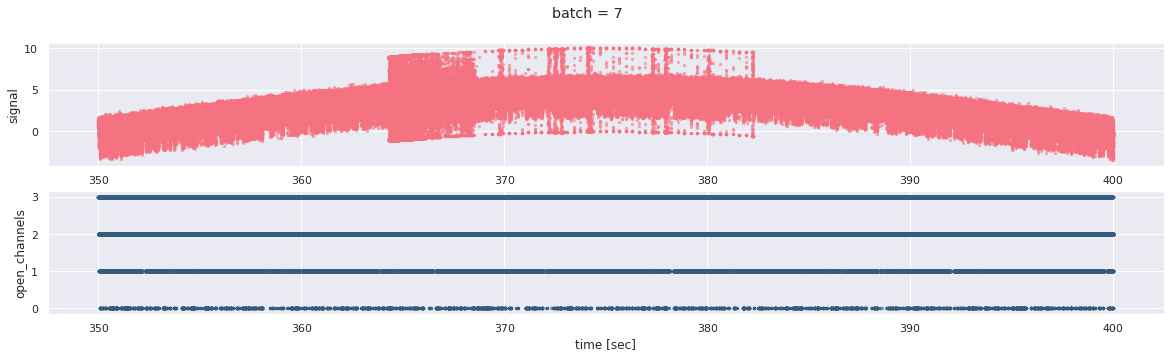

In [46]:
fig, axs = plt.subplots(2, 1, figsize=(20, 5))
axs = axs.ravel()
fig.suptitle(f'batch = {batch}')

axs[0].scatter(df_tr_batch['time'].values, df_tr_batch['signal'].values, color=cp[1], alpha=0.5, s=5)
axs[0].set_ylabel('signal')
axs[1].scatter(df_tr_batch['time'].values, df_tr_batch['open_channels'].values, color=cp[4], alpha=0.5, s=5)
axs[1].set_ylabel('open_channels')
axs[1].set_xlabel('time [sec]')

> なんじゃこりゃ  
> batch 0, 4と違って、signalとopen_channels が比例しているようには見えない

<br>

350~350.2秒を可視化

Text(0.5, 0, 'time [sec]')

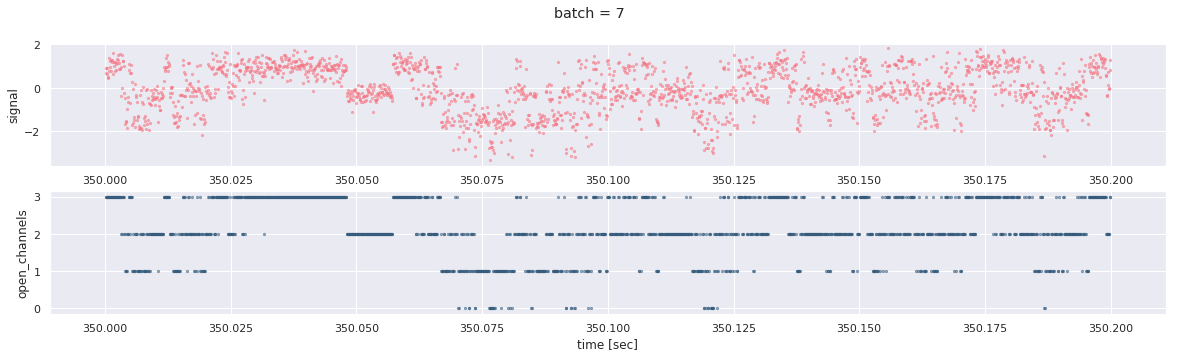

In [48]:
start_sec = 350
end_sec = 350.2

idxs = (start_sec<df_tr['time'].values) & (df_tr['time'].values<end_sec)
_df = df_tr[idxs]

fig, axs = plt.subplots(2, 1, figsize=(20, 5))
axs = axs.ravel()
fig.suptitle(f'batch = {batch}')

axs[0].scatter(_df['time'].values, _df['signal'].values, color=cp[1], alpha=0.5, s=5)
axs[0].set_ylabel('signal')
axs[1].scatter(_df['time'].values, _df['open_channels'].values, color=cp[4], alpha=0.5, s=5)
axs[1].set_ylabel('open_channels')
axs[1].set_xlabel('time [sec]')

> これはまあ、signalの大きさにopen_channelsが比例しているように見える

<br>
365~366 を拡大

Text(0.5, 0, 'time [sec]')

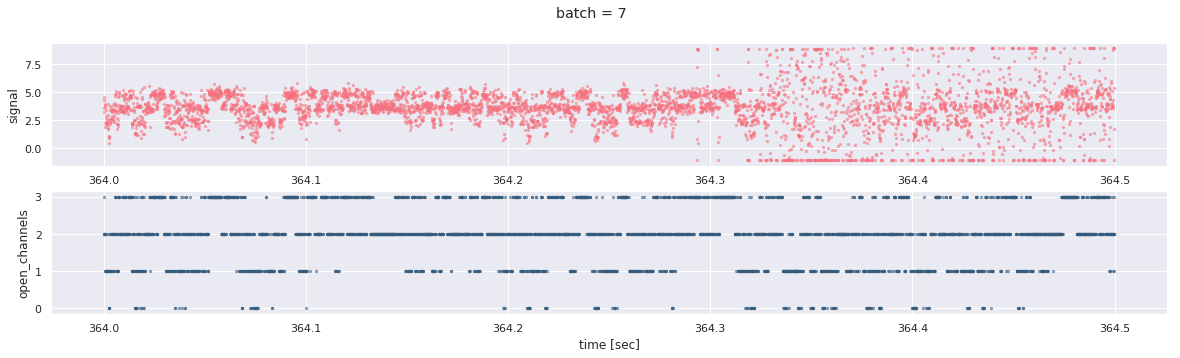

In [51]:
start_sec = 364
end_sec = 364.5

idxs = (start_sec<df_tr['time'].values) & (df_tr['time'].values<end_sec)
_df = df_tr[idxs]

fig, axs = plt.subplots(2, 1, figsize=(20, 5))
axs = axs.ravel()
fig.suptitle(f'batch = {batch}')

axs[0].scatter(_df['time'].values, _df['signal'].values, color=cp[1], alpha=0.5, s=5)
axs[0].set_ylabel('signal')
axs[1].scatter(_df['time'].values, _df['open_channels'].values, color=cp[4], alpha=0.5, s=5)
axs[1].set_ylabel('open_channels')
axs[1].set_xlabel('time [sec]')

> 364.3 秒付近で様子が変わっている。364.3以降はランダムに見えるんだが...

<br>
364.4~364.5 を拡大

Text(0.5, 0, 'time [sec]')

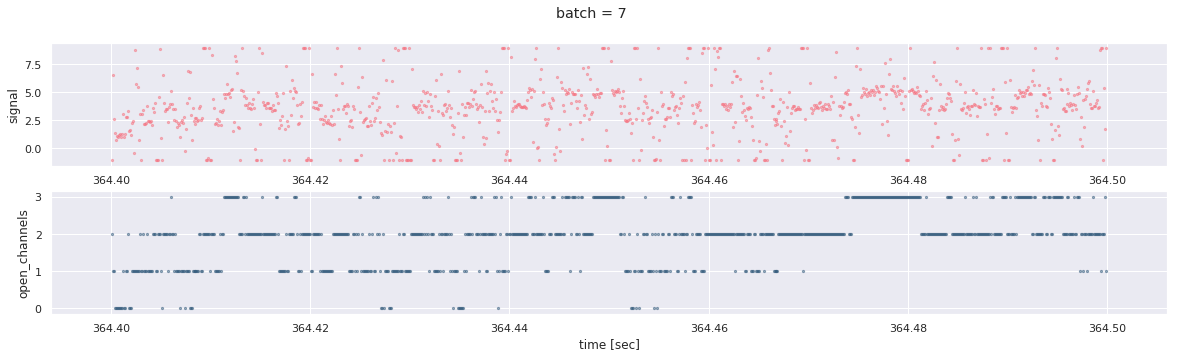

In [53]:
start_sec = 364.4
end_sec = 364.5

idxs = (start_sec<df_tr['time'].values) & (df_tr['time'].values<end_sec)
_df = df_tr[idxs]

fig, axs = plt.subplots(2, 1, figsize=(20, 5))
axs = axs.ravel()
fig.suptitle(f'batch = {batch}')

axs[0].scatter(_df['time'].values, _df['signal'].values, color=cp[1], alpha=0.5, s=5)
axs[0].set_ylabel('signal')
axs[1].scatter(_df['time'].values, _df['open_channels'].values, color=cp[4], alpha=0.5, s=5)
axs[1].set_ylabel('open_channels')
axs[1].set_xlabel('time [sec]')

> これは...まじでランダムに見えるんだが...  
> 予測できるのかこれ...

## batch=6 に絞って見てみる
> signalがアーチ状になっているので、signalから移動平均を引けばいい感じになるんじゃないかなと

In [54]:
batch = 6
idxs = df_tr['batch'] == batch
df_tr_batch = df_tr[idxs].copy()

<br>

signal の 移動平均も同時に可視化

Text(0.5, 0, 'time [sec]')

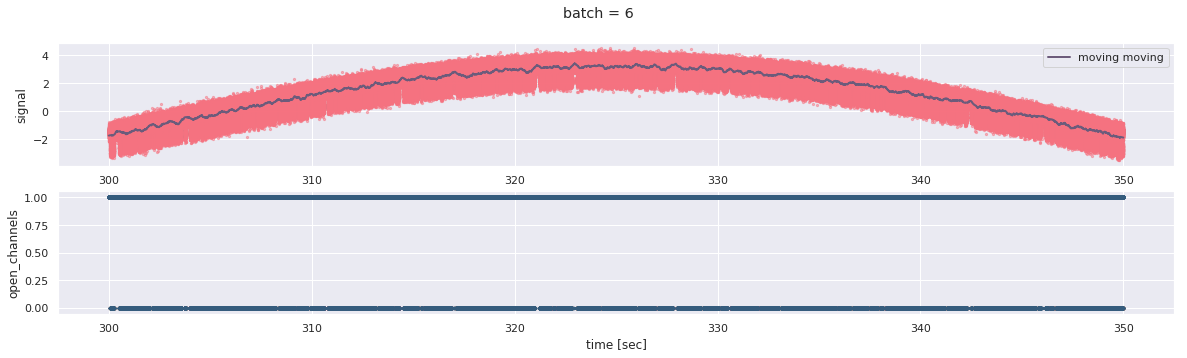

In [100]:
signal_mv = df_tr_batch['signal'].rolling(3001, center=True).mean().interpolate('spline', order=5, limit_direction='both').values

fig, axs = plt.subplots(2, 1, figsize=(20, 5))
axs = axs.ravel()
fig.suptitle(f'batch = {batch}')

axs[0].scatter(df_tr_batch['time'].values, df_tr_batch['signal'].values, color=cp[1], alpha=0.5, s=5)
axs[0].plot(df_tr_batch['time'].values, signal_mv, color=cp[3], linewidth=2, label='moving moving')
axs[0].set_ylabel('signal')
axs[0].legend()
axs[1].scatter(df_tr_batch['time'].values, df_tr_batch['open_channels'].values, color=cp[4], alpha=0.5, s=5)
axs[1].set_ylabel('open_channels')
axs[1].set_xlabel('time [sec]')

Text(0.5, 0, 'time [sec]')

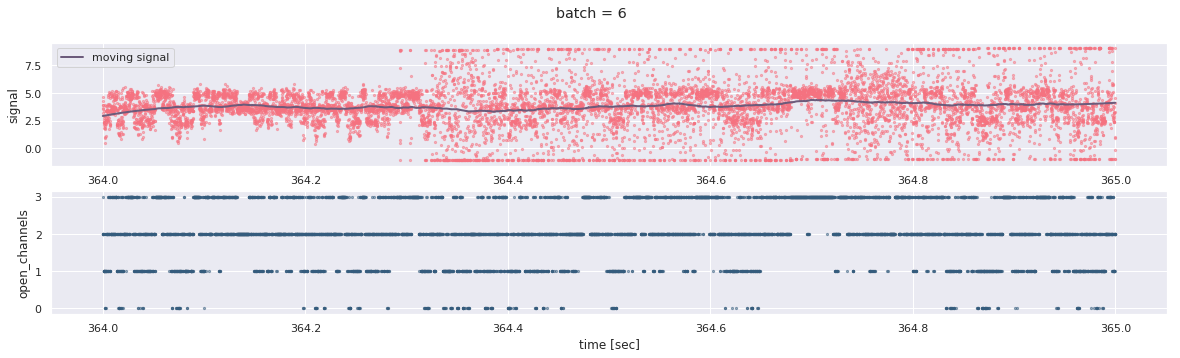

In [102]:
start_sec = 364
end_sec = 365

idxs = (start_sec<df_tr['time'].values) & (df_tr['time'].values<end_sec)
_df = df_tr[idxs]

# 移動平均
signal_mv = _df['signal'].rolling(1001, center=True).mean().interpolate('spline', order=5, limit_direction='both').values

fig, axs = plt.subplots(2, 1, figsize=(20, 5))
axs = axs.ravel()
fig.suptitle(f'batch = {batch}')

axs[0].scatter(_df['time'].values, _df['signal'].values, color=cp[1], alpha=0.5, s=5)
axs[0].plot(_df['time'].values, signal_mv, color=cp[3], linewidth=2, label='moving signal')
axs[0].set_ylabel('signal')
axs[0].legend()
axs[1].scatter(_df['time'].values, _df['open_channels'].values, color=cp[4], alpha=0.5, s=5)
axs[1].set_ylabel('open_channels')
axs[1].set_xlabel('time [sec]')

## batch=8 で 移動平均の効果を見てみる
- signal vs open_channels と signal-signal_mv vs open_channles の比較

In [115]:
batch = 8
idxs = df_tr['batch'] == batch
df_tr_batch = df_tr[idxs].copy()

<br>

signal の 移動平均も同時に可視化

Text(0.5, 0, 'time [sec]')

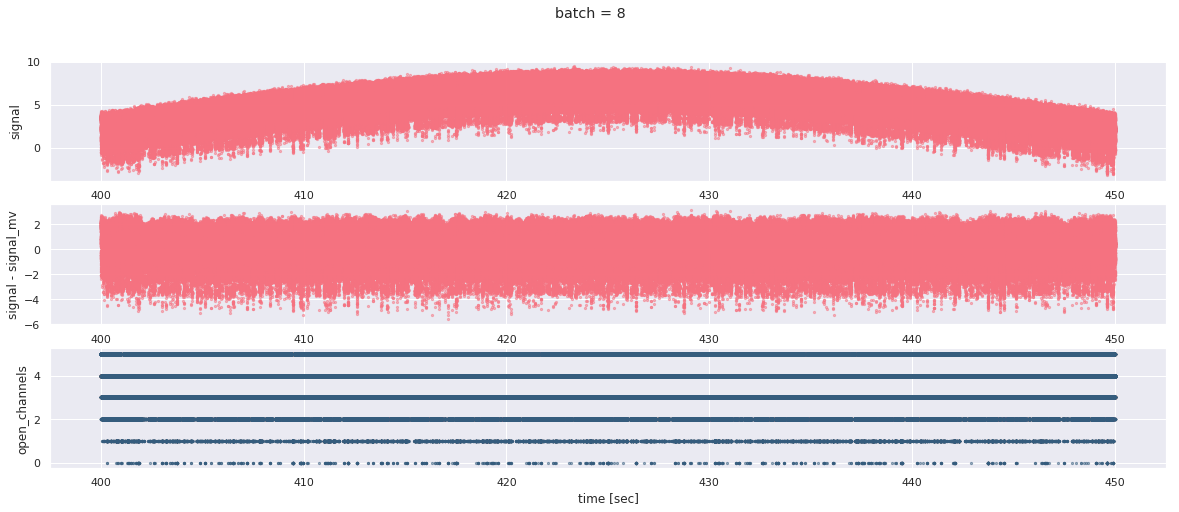

In [120]:
signal_mv = df_tr_batch['signal'].rolling(3001, center=True).mean().interpolate('spline', order=5, limit_direction='both').values
diff_signal_mv = df_tr_batch['signal'].values - signal_mv

fig, axs = plt.subplots(3, 1, figsize=(20, 7.5))
axs = axs.ravel()
fig.suptitle(f'batch = {batch}')

axs[0].scatter(df_tr_batch['time'].values, df_tr_batch['signal'], color=cp[1], alpha=0.5, s=5)
axs[0].set_ylabel('signal')
axs[1].scatter(df_tr_batch['time'].values, diff_signal_mv, color=cp[1], alpha=0.5, s=5)
axs[1].set_ylabel('signal - signal_mv')
axs[2].scatter(df_tr_batch['time'].values, df_tr_batch['open_channels'].values, color=cp[4], alpha=0.5, s=5)
axs[2].set_ylabel('open_channels')
axs[2].set_xlabel('time [sec]')

> アーチがなくなった!!   
> 次は相関を見てみよう

<br>
相関を見てみる

Text(0, 0.5, 'signal - signal_mv')

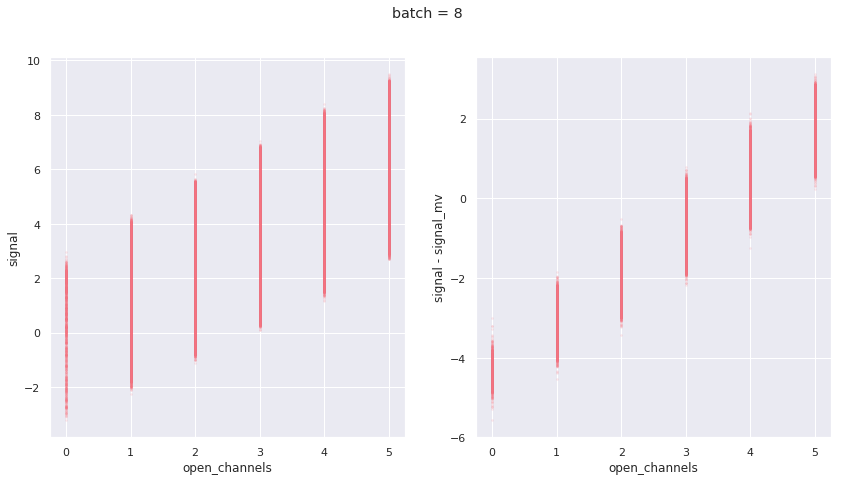

In [122]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs = axs.ravel()
fig.suptitle(f'batch = {batch}')

axs[0].scatter(df_tr_batch['open_channels'].values, df_tr_batch['signal'].values, alpha=0.1, s=3, color=cp[1])
axs[1].scatter(df_tr_batch['open_channels'].values, diff_signal_mv, alpha=0.1, s=3, color=cp[1])

axs[0].set_xlabel('open_channels')
axs[0].set_ylabel('signal')
axs[1].set_xlabel('open_channels')
axs[1].set_ylabel('signal - signal_mv')

> あきらかに形よくなった!!

## batch=7 で 移動平均の効果を見てみる
- signal vs open_channels と signal-signal_mv vs open_channles の比較

In [123]:
batch = 7
idxs = df_tr['batch'] == batch
df_tr_batch = df_tr[idxs].copy()

<br>

signal の 移動平均も同時に可視化

Text(0.5, 0, 'time [sec]')

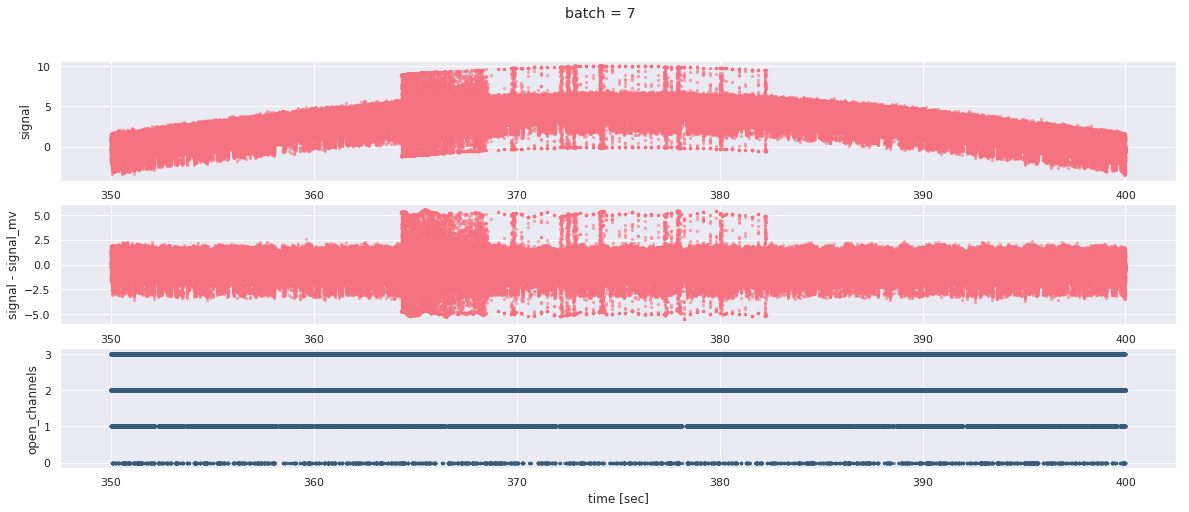

In [124]:
signal_mv = df_tr_batch['signal'].rolling(3001, center=True).mean().interpolate('spline', order=5, limit_direction='both').values
diff_signal_mv = df_tr_batch['signal'].values - signal_mv

fig, axs = plt.subplots(3, 1, figsize=(20, 7.5))
axs = axs.ravel()
fig.suptitle(f'batch = {batch}')

axs[0].scatter(df_tr_batch['time'].values, df_tr_batch['signal'], color=cp[1], alpha=0.5, s=5)
axs[0].set_ylabel('signal')
axs[1].scatter(df_tr_batch['time'].values, diff_signal_mv, color=cp[1], alpha=0.5, s=5)
axs[1].set_ylabel('signal - signal_mv')
axs[2].scatter(df_tr_batch['time'].values, df_tr_batch['open_channels'].values, color=cp[4], alpha=0.5, s=5)
axs[2].set_ylabel('open_channels')
axs[2].set_xlabel('time [sec]')

> アーチがなくなった!!   
> 次は相関を見てみよう

<br>
相関を見てみる

Text(0, 0.5, 'signal - signal_mv')

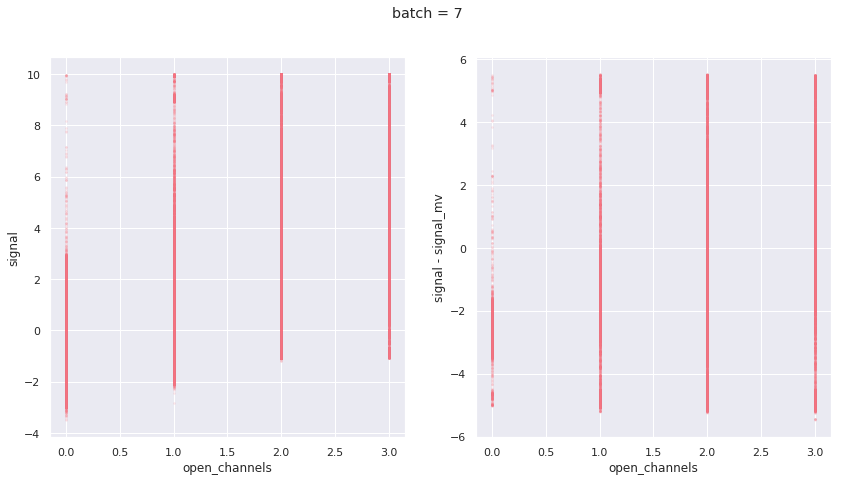

In [125]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs = axs.ravel()
fig.suptitle(f'batch = {batch}')

axs[0].scatter(df_tr_batch['open_channels'].values, df_tr_batch['signal'].values, alpha=0.1, s=3, color=cp[1])
axs[1].scatter(df_tr_batch['open_channels'].values, diff_signal_mv, alpha=0.1, s=3, color=cp[1])

axs[0].set_xlabel('open_channels')
axs[0].set_ylabel('signal')
axs[1].set_xlabel('open_channels')
axs[1].set_ylabel('signal - signal_mv')

> めっちゃ微妙だな...

# Experiments
- batch 8 で実験する
- signal-signal_mv の特徴量を加えたらどうなるか比較する

In [126]:
batch = 8 
idxs = df_tr['batch'] == batch
df_tr_batch = df_tr[idxs].copy()

<br>
移動平均を計算

In [129]:
signal_mv = df_tr_batch['signal'].rolling(3001, center=True).mean().interpolate('spline', order=5, limit_direction='both').values
diff_signal_mv = df_tr_batch['signal'].values - signal_mv
df_tr_batch['diff_signal_mv'] = diff_signal_mv
df_tr_batch['signal_mv'] = signal_mv

<br>

学習

feat: Index(['signal', 'signal_mv'], dtype='object')
[signal] f1_macro: 0.9230


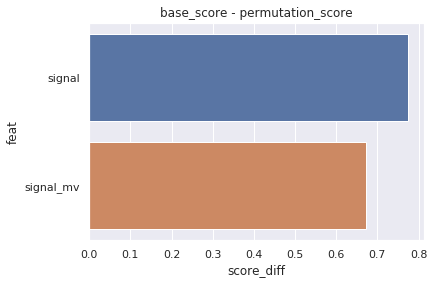


feat: Index(['diff_signal_mv', 'signal_mv', 'signal'], dtype='object')
[signal - signal_mv] f1_macro: 0.9220


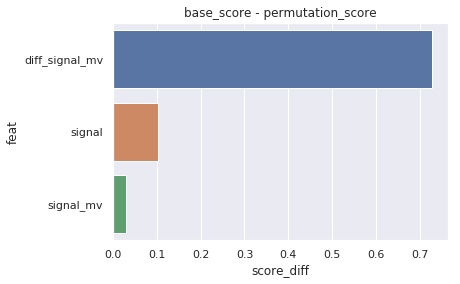


CPU times: user 22.5 s, sys: 300 ms, total: 22.8 s
Wall time: 22.2 s


In [150]:
%%time
# signal
X_train, X_valid, y_train, y_valid = train_test_split(df_tr_batch[['signal', 'signal_mv']], df_tr_batch['open_channels'], test_size=0.33, random_state=42)
model = RandomForestRegressor(n_estimators=10)
model.fit(X_train, y_train)
y_valid_pred = model.predict(X_valid)
y_valid_pred_round = np.round(y_valid_pred).astype('int8')
print(f'feat: {X_train.columns}')
print(f'[signal] f1_macro: {f1_score(y_valid, y_valid_pred_round, average="macro"):.4f}')
pi = permutation_importance(model, f1_macro) # model と metric を渡す
pi.compute(X_valid, y_valid)
pi.show_permutation_importance(score_type='accuracy')  # loss or accuracy
plt.show()
print('')

# signal - signal_mv
X_train, X_valid, y_train, y_valid = train_test_split(df_tr_batch[['diff_signal_mv', 'signal_mv', 'signal']], df_tr_batch['open_channels'], test_size=0.33, random_state=42)
model = RandomForestRegressor(n_estimators=10)
model.fit(X_train, y_train)
y_valid_pred = model.predict(X_valid)
y_valid_pred_round = np.round(y_valid_pred).astype('int8')
print(f'feat: {X_train.columns}')
print(f'[signal - signal_mv] f1_macro: {f1_score(y_valid, y_valid_pred_round, average="macro"):.4f}')
pi = permutation_importance(model, f1_macro) # model と metric を渡す
pi.compute(X_valid, y_valid)
pi.show_permutation_importance(score_type='accuracy')  # loss or accuracy
plt.show()
print('')

> diff_signal_mv がめっちゃ効いてる

> というか、f1_score めちゃくちゃいいんだけど...    
> batchごとに実験してみたほうがいいか？

# get_df_batch の実装
- df と batchの番号 を渡して、そのbatchに対応するdfを返す 

In [162]:
def get_df_batch(df, batch):
    idxs = df['batch'] == batch
    assert any(idxs), 'そのようなbatchはありません'
    return df[idxs]
    
_df = get_df_batch(df_tr, 3)
_df.head()

,time,signal,open_channels,batch
1500000,150.0001,0.3070,3,3
1500001,150.0002,0.9546,3,3
1500002,150.0003,1.2085,3,3
1500003,150.0004,1.2103,3,3
1500004,150.0005,1.1549,3,3


# get_mv 関数の実装
- batchごとに処理する
- 引数に移動平均の大きさを入れる

In [174]:
def get_signal_mv(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in progress_bar(df['batch'].unique()):
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).mean().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

In [173]:
%%time
signal_mv = get_signal_mv(df_tr, n=3001)

CPU times: user 1.53 s, sys: 108 ms, total: 1.64 s
Wall time: 1.63 s
